# Jan 2019 New functionalities examples

Example demonstrating how to use the torque_tube functionality.

#### Prerequisites (Step 0):
We assume all instalation is working at this point, reffer to the other journals for this! 

# Torque Tube Example (Hex!)

In [3]:
import sys

sys.path.insert(0, '../bifacial_radiance')

try:
    from bifacial_radiance import *
    import pkg_resources
    version = pkg_resources.get_distribution("bifacial_radiance").version
    print " Successful import of bifacial_radiance version {}".format(version)
except ImportError:
    raise RuntimeError('bifacial_radiance is required. download distribution')
    # Simple example system using Radiance.

 Successful import of bifacial_radiance version 0.2.3


In [2]:
# The below routine creates a HEXAGONAL torque tube, for a 2-UP configuration of a specific module size. Parameters for the module, the torque tube, and the scene are below.
# This is being run with gendaylit, for one specific timestamp

timestamp = 4020 # Noon, June 17th. 
simulationname = 'Torque_tube_hex_test'

# MakeModule Parameters
module_type='my_custom_panel'
x = 1.996  # 2-up portrait Longi with 15cm additional gap
y = 0.991
orientation='portrait' 
tilt = 10

# TorqueTube Parameters
torqueTube = True
numpanels = 2
gap = 0.15
tubetype = 'Hex'
disttopanel = 0.175
diameter = 0.15
torqueTubeMaterial = 'Metal_Grey'       # IT's NOT GRAY, IT's GREY

# SceneDict Parameters
gcr = 0.33   # ground cover ratio,  = module_height / pitch
albedo = 0.28  #'concrete'     # ground albedo
clearance_height = 2.35   
azimuth_ang=90
sensorsy = 200 # Notice we will be doing 200 sensors! It takes more time but gives better resolution.
psx = 0.05

In [3]:
# MODIFY THE TEST FOLDER TO YOUR LIKING. I utmostly dislike the interactive directory.
testfolder = r'C:\Users\sayala\Documents\RadianceScenes\Demo2'

In [6]:
# Now let's run the example

demo = RadianceObj('Torque_tube_hex_test',path = testfolder)  # Create a RadianceObj 'object'
demo.setGround(0.62) # input albedo number or material name like 'concrete'.  To see options, run this without any input.
epwfile = demo.getEPW(37.5,-77.6) # pull TMY data for any global lat/lon
metdata = demo.readEPW(epwfile) # read in the EPW weather data from above
demo.gendaylit(metdata,4020)  # Noon, June 17th

# Making module with all the variables
moduledict=demo.makeModule(name=module_type,x=x,y=y,bifi=1, 
           torquetube=torqueTube, diameter = diameter, tubetype = tubetype, material = torqueTubeMaterial, tubeZgap = disttopanel, numpanels = numpanels, panelgap = gap, rewriteModulefile = True, psx=psx)
# create a scene with all the variables
sceneDict = {'tilt':tilt,'pitch': np.round(moduledict['collector_width'] / gcr,3),'height':clearance_height,'azimuth':azimuth_ang, 'module_type':module_type}  

scene = demo.makeScene(moduletype=module_type, sceneDict=sceneDict, nMods = 20, nRows = 7, sensorsy = sensorsy, psx = psx) #makeScene creates a .rad file with 20 modules per row, 7 rows.
octfile = demo.makeOct(demo.getfilelist())  # makeOct combines all of the ground, sky and object files into a .oct file.


path = C:\Users\sayala\Documents\RadianceScenes\Demo2
Getting weather file: USA_VA_Richmond.Intl.AP.724010_TMY.epw  ... OK!
('\nModule Name:', 'my_custom_panel')
Module file did not exist before, creating new module file
Module my_custom_panel successfully created
Created Torque_tube_hex_test.oct


At this point you should be able to go into a command window (cmd.exe) and check the geometry. Example:
    
   ## rvu -vf views\front.vp -e .01 Torque_tube_hex_test.oct
   
   And then proceed happily with your analysis:

In [7]:
analysis = AnalysisObj(octfile, demo.name)  # return an analysis object including the scan dimensions for back irradiance
analysis.analysis(octfile, demo.name, scene.frontscan, scene.backscan)  # compare the back vs front irradiance  
print('Annual bifacial ratio average:  %0.3f' %( sum(analysis.Wm2Back) / sum(analysis.Wm2Front) ) )


Linescan in process: Torque_tube_hex_test_Front
Linescan in process: Torque_tube_hex_test_Back
Saved: results\irr_Torque_tube_hex_test.csv
Annual bifacial ratio average:  0.411


And then you dance-dance-dance. Except that, at the current stage of the software, if you open the results you will notice that now some of the sensors are measuring the irradinace at the torque tube and must die... in a future version.

(or increase the number of sensors by a lot and take them down in a separate routine in matlab all pretily and interpolate to have a consistent number of sensors with data while single axis tracking).

# Single-axis-tracking by HOUR example

Think of this as a fixed-tilt where the clearance height and the tracker tilt is changing. So the angles have to be re-calculated for every timestamp.

In [8]:
#Some variables again. Assuming bifacial_radiance was imported.

timeindex = 4020 # Noon, June 17th. 
simulationname = '1axisTrack'+str(timeindex)

# MakeModule Parameters
module_type='my_little_pony_panel'
x = 1.996  # 2-up portrait Longi with 15cm additional gap
y = 0.991
tilt = 10

# Tracking Angle Calculation Parameters
hub_height = 2.35   
axis_azimuth = 180.0
roundTrackerAngleBool = True 
angledelta = 5
limit_angle = 45
backtrack = True
    
# SceneDict Parameters
gcr = 0.33   # ground cover ratio,  = module_height / pitch
albedo = 0.28  #'concrete'     # ground albedo

In [9]:
#separate folder for this example
testfolder = r'C:\Users\sayala\Documents\RadianceScenes\Demo2'

In [13]:
# Running the simulation
demo2 = RadianceObj(simulationname, path = testfolder)  # Create a RadianceObj 'object' named 'demo'
demo2.setGround(albedo) # input albedo number or material name like 'concrete'.  To see options, run this without any input.
epwfile = demo2.getEPW(37.5,-77.6) # pull TMY data for any global lat/lon
metdata = demo2.readEPW(epwfile) # read in the weather data
demo2.gendaylit(metdata, 4020)  # Noon, June 17th

moduledict=demo2.makeModule(name=module_type,x=x,y=y)    
tracker_theta, tracker_height, azimuth_ang = demo2._getTrackingGeometryTimeIndex(metdata, timeindex=timeindex, angledelta = angledelta, roundTrackerAngleBool = roundTrackerAngleBool, axis_azimuth = axis_azimuth, limit_angle = limit_angle, backtrack = backtrack, gcr = gcr, hubheight = hub_height, module_height =  moduledict['collector_width'] )
sceneDict = {'tilt':tracker_theta,'pitch': moduledict['collector_width'] / gcr,'height':tracker_height,'azimuth':azimuth_ang, 'module_type':module_type}  
scene = demo2.makeScene(module_type, sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.
octfile = demo2.makeOct(demo2.getfilelist())  # makeOct combines all of the ground, sky and object files into a .oct file.

path = C:\Users\sayala\Documents\RadianceScenes\Demo2
Getting weather file: USA_VA_Richmond.Intl.AP.724010_TMY.epw  ... OK!
('\nModule Name:', 'my_little_pony_panel')
Module file did not exist before, creating new module file
Module my_little_pony_panel successfully created
For this timestamp, panels are facing West
Tracker theta has been calculated to 4.722 and rounded to nearest tracking angle 5.0
Module clearance height has been calculated to 2.307, for this tracker theta.
Created 1axisTrack4020.oct


At this point you should be able to go into a command window (cmd.exe) and check the geometry. Example:
    
   ## rvu -vf views\front.vp -e .01 Torque_tube_hex_test.oct
   
   And then proceed happily with your analysis:

In [14]:
analysis = AnalysisObj(octfile, demo2.basename)  # return an analysis object including the scan dimensions for back irradiance
frontDict, backDict = analysis.analysis(octfile, demo2.basename, scene.frontscan, scene.backscan)  # compare the back vs front irradiance  
print('Annual bifacial ratio: %0.3f - %0.3f' %(min(analysis.backRatio), np.mean(analysis.backRatio)) )

Linescan in process: 1axisTrack4020_Front
Linescan in process: 1axisTrack4020_Back
Saved: results\irr_1axisTrack4020.csv
Annual bifacial ratio: 0.188 - 0.189


After you set up your system parameters, you can just change the timestamp and evaluate any day. You could also use gendaylit2manual to pass specific DNI/DHI if you so wanted.

Enjoy!

# Add Custom Elements to your Scene
This shows how to add a custom element, in this case a Cube, that will be placed in the center of your scene to mark the 0,0 location. A tracking-example with torque tube is used.

In [15]:
#First all the Variables:
testfolder = r'C:\Users\sayala\Documents\RadianceScenes\demo'

#Some variables again. Assuming bifacial_radiance was imported.

timeindex = 4020 # Noon, June 17th. 
simulationname = '1axisTrack'+str(timeindex)

# MakeModule Parameters
module_type='my_little_pony_panel'
x = 1.996  # 2-up portrait Longi with 15cm additional gap
y = 0.991
tilt = 10

# Tracking Angle Calculation Parameters
hub_height = 0.5   
axis_azimuth = 180.0
roundTrackerAngleBool = True 
angledelta = 5
limit_angle = 45
backtrack = True
    
# SceneDict Parameters
gcr = 0.33   # ground cover ratio,  = module_height / pitch
albedo = 0.28  #'concrete'     # ground albedo

# Running the simulation
demo2 = RadianceObj(simulationname, path = testfolder)  # Create a RadianceObj 'object' named 'demo'
demo2.setGround(albedo) # input albedo number or material name like 'concrete'.  To see options, run this without any input.
epwfile = demo2.getEPW(37.5,-77.6) # pull TMY data for any global lat/lon
metdata = demo2.readEPW(epwfile) # read in the weather data
demo2.gendaylit(metdata, 4020)  # Noon, June 17th

path = C:\Users\sayala\Documents\RadianceScenes\demo
Getting weather file: USA_VA_Richmond.Intl.AP.724010_TMY.epw  ... OK!


'skies\\sky2_1axisTrack4020.rad'

We are going to create a "Mycube.rad" file in the objects folder, right after we make the Module. 
This is a prism (so we use 'genbox'), that is black from the ground.rad list of materials ('black')
We are naming it 'cuteBox'
Its sides are going to be 0.5x0.5x0.5 m 
and We are going to leave its bottom surface coincident with the plane z=0, but going to center on X and Y.
The command for this description is :
>'! genbox black PVmodule 0.5 0.5 0.5 | xform -t -0.25 -0.25 0'


In [16]:
moduledict=demo2.makeModule(name=module_type,x=x,y=y)   
name='Mycube'
text='! genbox black cuteBox 0.5 0.5 0.5 | xform -t -0.25 -0.25 0'
customObject = demo2.makeCustomObject(name,text)


('\nModule Name:', 'my_little_pony_panel')
REWRITING pre-existing module file. 
Module my_little_pony_panel successfully created
('\nCustom Object Name', 'objects\\Mycube.rad')


We are saving the filename and address into customObject so we can call it when making the Scene and add it to it.

At this point, you can go to the objects folder and check that the object was created properly.
### objects\\Mycube.rad

Let's create teh SCene now:

In [19]:
tracker_theta, tracker_height, azimuth_ang = demo2._getTrackingGeometryTimeIndex(metdata, timeindex=timeindex, angledelta = angledelta, roundTrackerAngleBool = roundTrackerAngleBool, axis_azimuth = axis_azimuth, limit_angle = limit_angle, backtrack = backtrack, gcr = gcr, hubheight = hub_height, module_height = moduledict['collector_width'] )
sceneDict = {'tilt':tracker_theta,'pitch': moduledict['collector_width'] / gcr,'height':tracker_height,'azimuth':azimuth_ang, 'module_type':module_type}  
scene = demo2.makeScene(module_type, sceneDict) #makeScene creates a .rad file with 20 modules per row, 7 rows.

For this timestamp, panels are facing West
Tracker theta has been calculated to 4.722 and rounded to nearest tracking angle 5.0
Module clearance height has been calculated to 0.457, for this tracker theta.


Now let's add the customObject to the Scene. We are not going to translate it or anything because we want it at the center, but you can pass translation, rotation, and any other XFORM command from Radiance.

I am passing a rotation 0 because xform has to have something (I think) otherwise it gets confused.

In [20]:
demo2.appendtoScene(scene.radfile, customObject, '!xform -rz 0')

octfile = demo2.makeOct(demo2.getfilelist())  # makeOct combines all of the ground, sky and object files into a .oct file.

Created 1axisTrack4020.oct


At this point you should be able to go into a command window (cmd.exe) and check the geometry. Example:
    
   #### rvu -vf views\front.vp -e .01 Torque_tube_hex_test.oct
   
And then proceed happily with your analysis. If any of the sensors hits the Box object we just created, the list of materials should say something with "cuteBox" on it. (That's why I set the clearance so low for this example, so the module and the cuteBox intercept).

In [21]:
analysis = AnalysisObj(octfile, demo2.basename)  # return an analysis object including the scan dimensions for back irradiance
frontDict, backDict = analysis.analysis(octfile, demo2.basename, scene.frontscan, scene.backscan)  # compare the back vs front irradiance  
print('Annual bifacial ratio: %0.3f - %0.3f' %(min(analysis.backRatio), np.mean(analysis.backRatio)) )

Linescan in process: 1axisTrack4020_Front
Linescan in process: 1axisTrack4020_Back
Saved: results\irr_1axisTrack4020.csv
Annual bifacial ratio: 0.000 - 0.065


# Read and clean RESULTS!
When using a gap between modules (or a torque tube for 1-up), some of the materials might end up being "sky", "ground", torquetube, or even inner sides of the modules themselves if the resolution is very high.

The following is an example on how to use the read1Result and cleanResult functions of this last update.

In [5]:
resultFile='C:\Users\sayala\Documents\RadianceScenes\Demo2\\results\irr_Torque_tube_hex_test.csv'
test = read1Result(resultFile)
nmodules = 2 # 2-up configuration. 
sensorsy = 200 # this was the original resolution. Since we are removing some sensors 
               # that end up in the gap, the routine will interpolate to get this same number of sensors.
               # it will interpolate to 100 sensors per panel for the 2-up configuration for this example.
sazm = 270 # for the timestamp analyzed, the panels were facing West. This is important because the sensors and modules must be switched so it matches when the geometry is rotated...
Front4240, Back4240 = deepcleanResult(test, sensorsy, nmodules, sazm, automatic=True)

Read Results has a10.3.hextube1a.6457 material at position 100, with Front irradiance 420.232533333  W/m^2
Cleaning the results removes this material, and leaves only modules.
Now the Front Irradiance value is 593.112133333 W/m^2


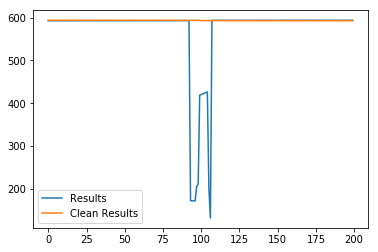

In [31]:
print("Read Results has {} material at position 100, with Front irradiance {}  W/m^2".format(test['mattype'][100],test['Wm2Front'][100]))
print("Cleaning the results removes this material, and leaves only modules.")
print("Now the Front Irradiance value is {} W/m^2".format(Front4240[100]))

import matplotlib.pyplot as plt
plt.plot(test['Wm2Front'], label='Results')
plt.plot(Front4240, label='Clean Results')
plt.legend()

200

Read Results has sky material at position 100, with Rear irradiance 262.1641
Cleaning the results removes this material, and leaves only modules.
Now the Rear Irradiance value is 208.0174 W/m^2
